# 🎶 음악 생성 - MuseGAN

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/11_music/02_musegan/musegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 musegan_utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/02_musegan/musegan_utils.py
    # output 디렉토리를 만듭니다.
    !mkdir parsed_data
    !mkdir output
    !mkdir bach-chorales
    # 악보 이미지 생성을 위해
    !apt-get install lilypond > /dev/null

--2023-11-09 13:50:11--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/02_musegan/musegan_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1833 (1.8K) [text/plain]
Saving to: ‘musegan_utils.py’

musegan_utils.py    100%[===================>]   1.79K  --.-KB/s    in 0s      

2023-11-09 13:50:12 (27.6 MB/s) - ‘musegan_utils.py’ saved [1833/1833]

Extracting templates from packages: 100%


이 노트북에서는 바흐 코랄 스타일의 음악을 생성하는 MuseGAN 모델을 훈련합니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

import os
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    callbacks,
    initializers,
    metrics,
)

from musegan_utils import notes_to_midi, draw_score

## 0. 파라미터 <a name="parameters"></a>

In [3]:
BATCH_SIZE = 64

N_BARS = 2
N_STEPS_PER_BAR = 16
MAX_PITCH = 83
N_PITCHES = MAX_PITCH + 1
Z_DIM = 32


CRITIC_STEPS = 5
GP_WEIGHT = 10
CRITIC_LEARNING_RATE = 0.001
GENERATOR_LEARNING_RATE = 0.001
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
EPOCHS = 1000
LOAD_MODEL = False

## 1. 데이터 준비

In [4]:
if 'google.colab' in sys.modules:
    !curl -LO https://github.com/czhuang/JSB-Chorales-dataset/raw/master/Jsb16thSeparated.npz -s
    !mv Jsb16thSeparated.npz bach-chorales

In [5]:
# 데이터 로드
file = os.path.join("./bach-chorales/Jsb16thSeparated.npz")
with np.load(file, encoding="bytes", allow_pickle=True) as f:
    data = f["train"]

In [6]:
N_SONGS = len(data)
print(f"데이터셋에 있는 코랄 개수: {N_SONGS}")
chorale = data[0]
N_BEATS, N_TRACKS = chorale.shape
print(f"코랄 0번의 크기: {N_BEATS, N_TRACKS}")
print("\n코랄 0")
print(chorale[:8])

데이터셋에 있는 코랄 개수: 229
코랄 0번의 크기: (192, 4)

코랄 0
[[74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [75. 70. 58. 55.]
 [75. 70. 58. 55.]
 [75. 70. 60. 55.]
 [75. 70. 60. 55.]]


In [7]:
two_bars = np.array([x[: (N_STEPS_PER_BAR * N_BARS)] for x in data])
two_bars = np.array(np.nan_to_num(two_bars, nan=MAX_PITCH), dtype=int)
two_bars = two_bars.reshape([N_SONGS, N_BARS, N_STEPS_PER_BAR, N_TRACKS])
print(f"두 마디 크기: {two_bars.shape}")

두 마디 크기: (229, 2, 16, 4)


In [8]:
data_binary = np.eye(N_PITCHES)[two_bars]
data_binary[data_binary == 0] = -1
data_binary = data_binary.transpose([0, 1, 2, 4, 3])
print(f"데이터 바이너리 크기: {data_binary.shape}")

데이터 바이너리 크기: (229, 2, 16, 84, 4)


## 2. GAN 구축 <a name="build"></a>

In [9]:
# 헬퍼 함수

initializer = initializers.RandomNormal(mean=0.0, stddev=0.02)


def conv(x, f, k, s, p):
    x = layers.Conv3D(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    x = layers.LeakyReLU()(x)
    return x


def conv_t(x, f, k, s, a, p, bn):
    x = layers.Conv2DTranspose(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    if bn:
        x = layers.BatchNormalization(momentum=0.9)(x)

    x = layers.Activation(a)(x)
    return x

In [10]:
def TemporalNetwork():
    input_layer = layers.Input(shape=(Z_DIM,), name="temporal_input")
    x = layers.Reshape([1, 1, Z_DIM])(input_layer)
    x = conv_t(x, f=1024, k=(2, 1), s=(1, 1), a="relu", p="valid", bn=True)
    x = conv_t(
        x, f=Z_DIM, k=(N_BARS - 1, 1), s=(1, 1), a="relu", p="valid", bn=True
    )
    output_layer = layers.Reshape([N_BARS, Z_DIM])(x)
    return models.Model(input_layer, output_layer)


TemporalNetwork().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 temporal_input (InputLayer  [(None, 32)]              0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 1, 1, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 2, 1, 1024)        66560     
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 2, 1, 1024)        4096      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 2, 1, 1024)        0         
                                                             

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [11]:
def BarGenerator():
    input_layer = layers.Input(shape=(Z_DIM * 4,), name="bar_generator_input")

    x = layers.Dense(1024)(input_layer)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.Activation("relu")(x)
    x = layers.Reshape([2, 1, 512])(x)

    x = conv_t(x, f=512, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(1, 7), s=(1, 7), a="relu", p="same", bn=True)
    x = conv_t(x, f=1, k=(1, 12), s=(1, 12), a="tanh", p="same", bn=False)

    output_layer = layers.Reshape([1, N_STEPS_PER_BAR, N_PITCHES, 1])(x)

    return models.Model(input_layer, output_layer)


BarGenerator().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bar_generator_input (Input  [(None, 128)]             0         
 Layer)                                                          
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                                 
 batch_normalization_2 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 1024)              0         
                                                                 
 reshape_2 (Reshape)         (None, 2, 1, 512)         0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 4, 1, 512)         5248

In [12]:
def Generator():
    chords_input = layers.Input(shape=(Z_DIM,), name="chords_input")
    style_input = layers.Input(shape=(Z_DIM,), name="style_input")
    melody_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="melody_input")
    groove_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="groove_input")

    # 코드 -> TemporalNetwork
    chords_tempNetwork = TemporalNetwork()
    chords_over_time = chords_tempNetwork(chords_input)  # [n_bars, z_dim]

    # 멜로디 -> TemporalNetwork
    melody_over_time = [
        None
    ] * N_TRACKS  # n_tracks개 [n_bars, z_dim] 텐서의 리스트
    melody_tempNetwork = [None] * N_TRACKS
    for track in range(N_TRACKS):
        melody_tempNetwork[track] = TemporalNetwork()
        melody_track = layers.Lambda(lambda x, track=track: x[:, track, :])(
            melody_input
        )
        melody_over_time[track] = melody_tempNetwork[track](melody_track)

    # 각 트랙에 대한 마디 생성자를 만듭니다.
    barGen = [None] * N_TRACKS
    for track in range(N_TRACKS):
        barGen[track] = BarGenerator()

    # 각 트랙과 마디에 대해 출력을 만듭니다.
    bars_output = [None] * N_BARS
    c = [None] * N_BARS
    for bar in range(N_BARS):
        track_output = [None] * N_TRACKS

        c[bar] = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
            chords_over_time
        )  # [z_dim]
        s = style_input  # [z_dim]

        for track in range(N_TRACKS):
            m = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
                melody_over_time[track]
            )  # [z_dim]
            g = layers.Lambda(lambda x, track=track: x[:, track, :])(
                groove_input
            )  # [z_dim]

            z_input = layers.Concatenate(
                axis=1, name="total_input_bar_{}_track_{}".format(bar, track)
            )([c[bar], s, m, g])

            track_output[track] = barGen[track](z_input)

        bars_output[bar] = layers.Concatenate(axis=-1)(track_output)

    generator_output = layers.Concatenate(axis=1, name="concat_bars")(
        bars_output
    )

    return models.Model(
        [chords_input, style_input, melody_input, groove_input],
        generator_output,
    )


generator = Generator()
generator.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 melody_input (InputLayer)   [(None, 4, 32)]              0         []                            
                                                                                                  
 chords_input (InputLayer)   [(None, 32)]                 0         []                            
                                                                                                  
 lambda (Lambda)             (None, 32)                   0         ['melody_input[0][0]']        
                                                                                                  
 lambda_1 (Lambda)           (None, 32)                   0         ['melody_input[0][0]']        
                                                                                           

In [13]:
def Critic():
    critic_input = layers.Input(
        shape=(N_BARS, N_STEPS_PER_BAR, N_PITCHES, N_TRACKS),
        name="critic_input",
    )

    x = critic_input

    x = conv(x, f=128, k=(2, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(N_BARS - 1, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(1, 1, 12), s=(1, 1, 12), p="same")
    x = conv(x, f=128, k=(1, 1, 7), s=(1, 1, 7), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=256, k=(1, 4, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=512, k=(1, 3, 1), s=(1, 2, 1), p="same")

    x = layers.Flatten()(x)

    x = layers.Dense(1024, kernel_initializer=initializer)(x)
    x = layers.LeakyReLU()(x)

    critic_output = layers.Dense(
        1, activation=None, kernel_initializer=initializer
    )(x)

    return models.Model(critic_input, critic_output)


critic = Critic()
critic.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 2, 16, 84, 4)]    0         
                                                                 
 conv3d (Conv3D)             (None, 1, 16, 84, 128)    1152      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 16, 84, 128)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 16, 84, 128)    16512     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 16, 84, 128)    0         
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 16, 7, 128)     196736    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1, 16, 7, 128)     0  

In [14]:
class MuseGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(MuseGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(MuseGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            chords_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            style_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            melody_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )
            groove_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )

            random_latent_vectors = [
                chords_random_latent_vectors,
                style_random_latent_vectors,
                melody_random_latent_vectors,
                groove_random_latent_vectors,
            ]

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        chords_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )

        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

    def generate_piano_roll(self, num_scores):
        chords_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]
        generated_music = self.generator(random_latent_vectors)
        generated_music = generated_music.numpy()
        return generated_music

In [15]:
# MuseGAN 만들기
musegan = MuseGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [16]:
if LOAD_MODEL:
    musegan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. MuseGAN 훈련하기 <a name="train"></a>

In [17]:
# GAN 컴파일
musegan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=CRITIC_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=GENERATOR_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
)

In [18]:
# 모델 저장 체크포인트 만들기
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

from IPython.display import Image

class MusicGenerator(callbacks.Callback):
    def __init__(self, num_scores):
        self.num_scores = num_scores

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:
            generated_music = self.model.generate_piano_roll(self.num_scores)
            notes_to_midi(
                generated_music,
                N_BARS,
                N_TRACKS,
                N_STEPS_PER_BAR,
                filename="output_" + str(epoch).zfill(4),
            )
            display(Image(str(draw_score("output_" + str(epoch).zfill(4), 0).write('lily.png'))))
            # draw_score(generated_music, 0)
            # display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch), cmap = None)


music_generator_callback = MusicGenerator(1)

Epoch 1/1000
8/8 [==============================] - ETA: 0s - c_loss: -509.7531 - c_wass_loss: -1332.1266 - c_gp: 82.2374 - g_loss: -331.2343

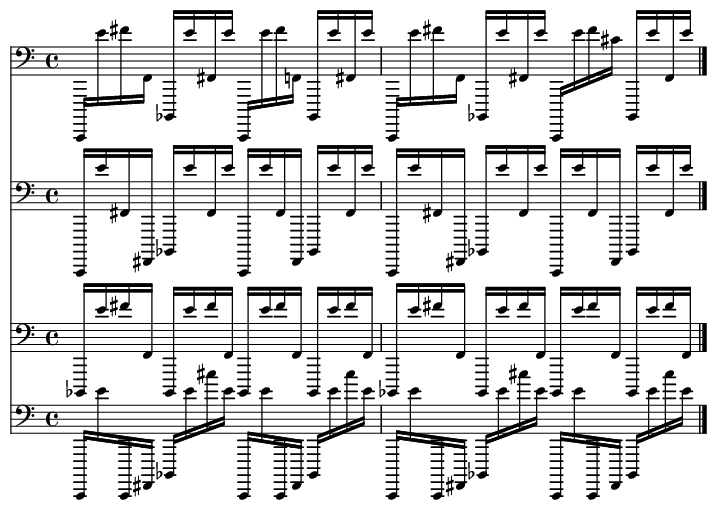

8/8 [==============================] - 77s 649ms/step - c_loss: -509.7531 - c_wass_loss: -1332.1266 - c_gp: 82.2374 - g_loss: -331.2343
Epoch 2/1000
8/8 [==============================] - 3s 369ms/step - c_loss: -110.2200 - c_wass_loss: -166.2727 - c_gp: 5.6053 - g_loss: -493.5844
Epoch 3/1000
8/8 [==============================] - 3s 325ms/step - c_loss: -37.8021 - c_wass_loss: -54.4330 - c_gp: 1.6631 - g_loss: -744.1182
Epoch 4/1000
8/8 [==============================] - 2s 318ms/step - c_loss: -53.8636 - c_wass_loss: -87.4922 - c_gp: 3.3629 - g_loss: -1003.4982
Epoch 5/1000
8/8 [==============================] - 2s 319ms/step - c_loss: -55.4483 - c_wass_loss: -77.5172 - c_gp: 2.2069 - g_loss: 472.4723
Epoch 6/1000
8/8 [==============================] - 2s 317ms/step - c_loss: -57.0896 - c_wass_loss: -81.3506 - c_gp: 2.4261 - g_loss: 724.2488
Epoch 7/1000
8/8 [==============================] - 3s 370ms/step - c_loss: -56.5617 - c_wass_loss: -81.0961 - c_gp: 2.4534 - g_loss: 1958.1379

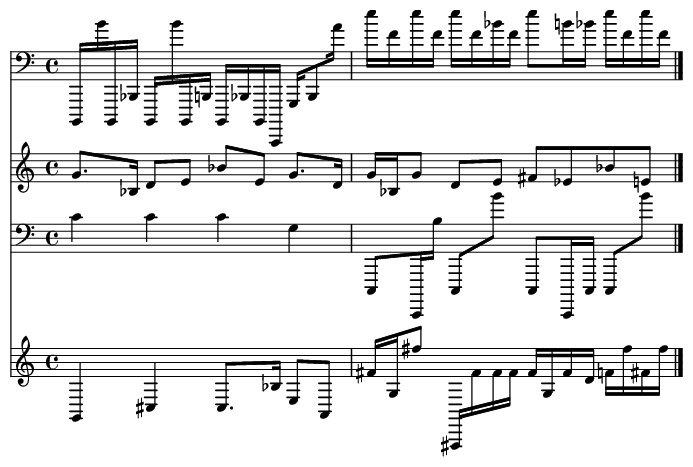

8/8 [==============================] - 4s 594ms/step - c_loss: -29.1522 - c_wass_loss: -37.8269 - c_gp: 0.8675 - g_loss: -71.8091
Epoch 102/1000
8/8 [==============================] - 3s 322ms/step - c_loss: -27.1208 - c_wass_loss: -39.8753 - c_gp: 1.2755 - g_loss: -67.3055
Epoch 103/1000
8/8 [==============================] - 2s 318ms/step - c_loss: -26.4509 - c_wass_loss: -33.4222 - c_gp: 0.6971 - g_loss: -210.1745
Epoch 104/1000
8/8 [==============================] - 2s 317ms/step - c_loss: -27.0849 - c_wass_loss: -37.1691 - c_gp: 1.0084 - g_loss: -99.4860
Epoch 105/1000
8/8 [==============================] - 3s 328ms/step - c_loss: -25.3521 - c_wass_loss: -32.6104 - c_gp: 0.7258 - g_loss: -84.5745
Epoch 106/1000
8/8 [==============================] - 3s 385ms/step - c_loss: -26.4483 - c_wass_loss: -34.9037 - c_gp: 0.8455 - g_loss: -65.8682
Epoch 107/1000
8/8 [==============================] - 3s 322ms/step - c_loss: -27.3967 - c_wass_loss: -38.1872 - c_gp: 1.0790 - g_loss: -164.247

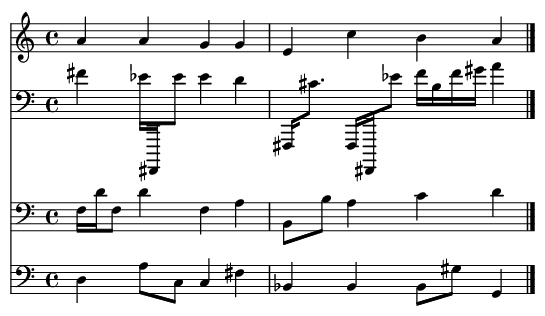

8/8 [==============================] - 4s 561ms/step - c_loss: -38.3972 - c_wass_loss: -58.4161 - c_gp: 2.0019 - g_loss: -21.6524
Epoch 202/1000
8/8 [==============================] - 3s 319ms/step - c_loss: -42.4955 - c_wass_loss: -57.7112 - c_gp: 1.5216 - g_loss: -33.8610
Epoch 203/1000
8/8 [==============================] - 2s 321ms/step - c_loss: -40.0690 - c_wass_loss: -57.1201 - c_gp: 1.7051 - g_loss: -18.7029
Epoch 204/1000
8/8 [==============================] - 2s 319ms/step - c_loss: -45.0384 - c_wass_loss: -57.8599 - c_gp: 1.2822 - g_loss: -31.9988
Epoch 205/1000
8/8 [==============================] - 3s 329ms/step - c_loss: -43.5392 - c_wass_loss: -63.9601 - c_gp: 2.0421 - g_loss: -22.3790
Epoch 206/1000
8/8 [==============================] - 3s 355ms/step - c_loss: -40.5394 - c_wass_loss: -65.0480 - c_gp: 2.4509 - g_loss: -27.4245
Epoch 207/1000
8/8 [==============================] - 3s 328ms/step - c_loss: -44.3520 - c_wass_loss: -62.5614 - c_gp: 1.8209 - g_loss: -30.6589


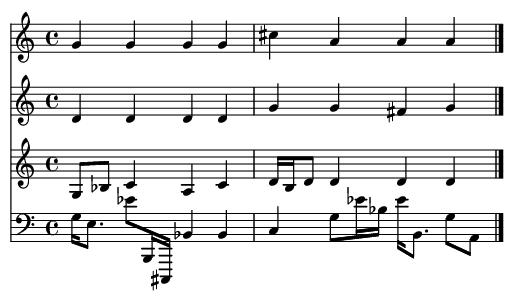

8/8 [==============================] - 3s 451ms/step - c_loss: -54.6765 - c_wass_loss: -73.4776 - c_gp: 1.8801 - g_loss: -21.3582
Epoch 302/1000
8/8 [==============================] - 2s 314ms/step - c_loss: -51.7715 - c_wass_loss: -74.2200 - c_gp: 2.2448 - g_loss: -25.3016
Epoch 303/1000
8/8 [==============================] - 2s 322ms/step - c_loss: -55.6061 - c_wass_loss: -77.3475 - c_gp: 2.1741 - g_loss: -20.1413
Epoch 304/1000
8/8 [==============================] - 3s 371ms/step - c_loss: -44.0871 - c_wass_loss: -88.4602 - c_gp: 4.4373 - g_loss: -31.3969
Epoch 305/1000
8/8 [==============================] - 3s 330ms/step - c_loss: -53.9350 - c_wass_loss: -76.8835 - c_gp: 2.2949 - g_loss: -13.7502
Epoch 306/1000
8/8 [==============================] - 3s 345ms/step - c_loss: -53.9882 - c_wass_loss: -76.5227 - c_gp: 2.2534 - g_loss: -20.0594
Epoch 307/1000
8/8 [==============================] - 2s 320ms/step - c_loss: -55.1911 - c_wass_loss: -88.9306 - c_gp: 3.3740 - g_loss: -24.4822


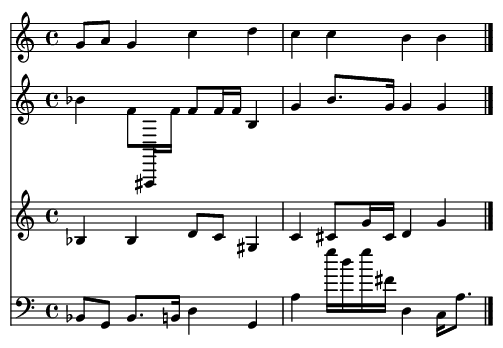

8/8 [==============================] - 3s 462ms/step - c_loss: -69.0446 - c_wass_loss: -100.2914 - c_gp: 3.1247 - g_loss: -25.1987
Epoch 402/1000
8/8 [==============================] - 2s 317ms/step - c_loss: -68.9174 - c_wass_loss: -97.1048 - c_gp: 2.8187 - g_loss: -25.7092
Epoch 403/1000
8/8 [==============================] - 3s 359ms/step - c_loss: -76.3595 - c_wass_loss: -107.1462 - c_gp: 3.0787 - g_loss: -23.5695
Epoch 404/1000
8/8 [==============================] - 3s 331ms/step - c_loss: -67.9485 - c_wass_loss: -100.9401 - c_gp: 3.2992 - g_loss: -21.7480
Epoch 405/1000
8/8 [==============================] - 2s 322ms/step - c_loss: -55.0903 - c_wass_loss: -104.8218 - c_gp: 4.9732 - g_loss: -17.1424
Epoch 406/1000
8/8 [==============================] - 3s 324ms/step - c_loss: -67.5616 - c_wass_loss: -106.7780 - c_gp: 3.9216 - g_loss: -8.7509
Epoch 407/1000
8/8 [==============================] - 2s 321ms/step - c_loss: -76.6174 - c_wass_loss: -108.2864 - c_gp: 3.1669 - g_loss: -10.

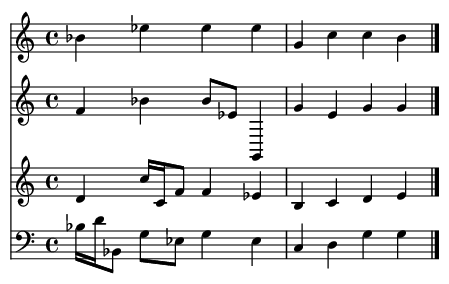

8/8 [==============================] - 4s 488ms/step - c_loss: -67.2279 - c_wass_loss: -118.6391 - c_gp: 5.1411 - g_loss: -23.6436
Epoch 502/1000
8/8 [==============================] - 3s 334ms/step - c_loss: -77.0066 - c_wass_loss: -120.1750 - c_gp: 4.3168 - g_loss: -32.5732
Epoch 503/1000
8/8 [==============================] - 2s 322ms/step - c_loss: -80.7423 - c_wass_loss: -112.2352 - c_gp: 3.1493 - g_loss: -19.4833
Epoch 504/1000
8/8 [==============================] - 2s 322ms/step - c_loss: -54.1482 - c_wass_loss: -123.8607 - c_gp: 6.9713 - g_loss: -12.2530
Epoch 505/1000
8/8 [==============================] - 2s 318ms/step - c_loss: -74.0862 - c_wass_loss: -112.0413 - c_gp: 3.7955 - g_loss: -11.4140
Epoch 506/1000
8/8 [==============================] - 3s 375ms/step - c_loss: -84.7168 - c_wass_loss: -128.2630 - c_gp: 4.3546 - g_loss: -3.3174
Epoch 507/1000
8/8 [==============================] - 3s 330ms/step - c_loss: -55.0783 - c_wass_loss: -115.2263 - c_gp: 6.0148 - g_loss: -7.

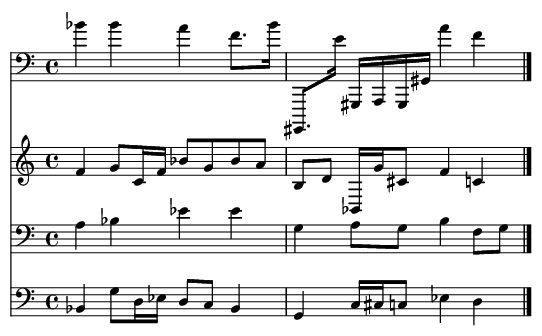

8/8 [==============================] - 4s 472ms/step - c_loss: -73.1991 - c_wass_loss: -128.4622 - c_gp: 5.5263 - g_loss: -15.8774
Epoch 602/1000
8/8 [==============================] - 2s 319ms/step - c_loss: -71.5443 - c_wass_loss: -120.2434 - c_gp: 4.8699 - g_loss: 6.8441
Epoch 603/1000
8/8 [==============================] - 2s 319ms/step - c_loss: -81.9167 - c_wass_loss: -116.4786 - c_gp: 3.4562 - g_loss: -16.3308
Epoch 604/1000
8/8 [==============================] - 2s 322ms/step - c_loss: -80.2803 - c_wass_loss: -122.4350 - c_gp: 4.2155 - g_loss: -11.6478
Epoch 605/1000
8/8 [==============================] - 3s 376ms/step - c_loss: -76.5976 - c_wass_loss: -137.7800 - c_gp: 6.1182 - g_loss: -14.7881
Epoch 606/1000
8/8 [==============================] - 3s 322ms/step - c_loss: -74.6187 - c_wass_loss: -128.9699 - c_gp: 5.4351 - g_loss: -7.6910
Epoch 607/1000
8/8 [==============================] - 2s 319ms/step - c_loss: -71.7135 - c_wass_loss: -120.0411 - c_gp: 4.8328 - g_loss: 19.17

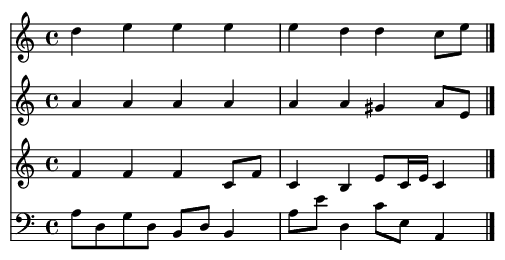

8/8 [==============================] - 3s 457ms/step - c_loss: -82.8991 - c_wass_loss: -125.9418 - c_gp: 4.3043 - g_loss: -10.4439
Epoch 702/1000
8/8 [==============================] - 2s 322ms/step - c_loss: -100.3471 - c_wass_loss: -145.9029 - c_gp: 4.5556 - g_loss: -16.0661
Epoch 703/1000
8/8 [==============================] - 3s 323ms/step - c_loss: -78.8737 - c_wass_loss: -134.3649 - c_gp: 5.5491 - g_loss: -2.0990
Epoch 704/1000
8/8 [==============================] - 3s 381ms/step - c_loss: -88.3896 - c_wass_loss: -129.2931 - c_gp: 4.0903 - g_loss: -3.7812
Epoch 705/1000
8/8 [==============================] - 3s 327ms/step - c_loss: -72.3802 - c_wass_loss: -129.7710 - c_gp: 5.7391 - g_loss: -12.7645
Epoch 706/1000
8/8 [==============================] - 3s 339ms/step - c_loss: -77.8447 - c_wass_loss: -128.1748 - c_gp: 5.0330 - g_loss: 0.4423
Epoch 707/1000
8/8 [==============================] - 2s 318ms/step - c_loss: -95.9874 - c_wass_loss: -141.7597 - c_gp: 4.5772 - g_loss: -1.65

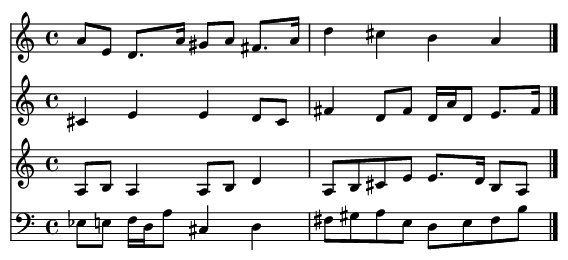

8/8 [==============================] - 3s 458ms/step - c_loss: -86.4916 - c_wass_loss: -132.1162 - c_gp: 4.5625 - g_loss: -8.4465
Epoch 802/1000
8/8 [==============================] - 3s 323ms/step - c_loss: -82.4953 - c_wass_loss: -138.5739 - c_gp: 5.6079 - g_loss: -2.1445
Epoch 803/1000
8/8 [==============================] - 3s 364ms/step - c_loss: -91.5710 - c_wass_loss: -133.8851 - c_gp: 4.2314 - g_loss: -3.0267
Epoch 804/1000
8/8 [==============================] - 2s 319ms/step - c_loss: -80.9815 - c_wass_loss: -139.1276 - c_gp: 5.8146 - g_loss: -13.2916
Epoch 805/1000
8/8 [==============================] - 2s 319ms/step - c_loss: -88.8734 - c_wass_loss: -134.5187 - c_gp: 4.5645 - g_loss: 10.5744
Epoch 806/1000
8/8 [==============================] - 2s 320ms/step - c_loss: -80.4075 - c_wass_loss: -144.5303 - c_gp: 6.4123 - g_loss: -17.8709
Epoch 807/1000
8/8 [==============================] - 3s 358ms/step - c_loss: -82.6575 - c_wass_loss: -126.6602 - c_gp: 4.4003 - g_loss: -7.933

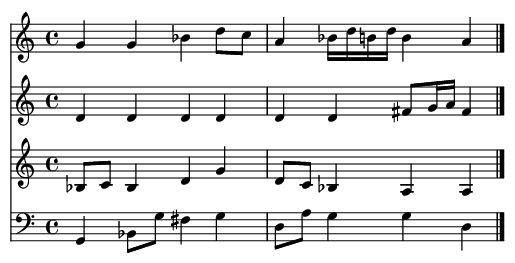

8/8 [==============================] - 4s 470ms/step - c_loss: -105.2888 - c_wass_loss: -143.8180 - c_gp: 3.8529 - g_loss: -19.5750
Epoch 902/1000
8/8 [==============================] - 3s 323ms/step - c_loss: -97.4312 - c_wass_loss: -163.6898 - c_gp: 6.6259 - g_loss: -13.0261
Epoch 903/1000
8/8 [==============================] - 3s 323ms/step - c_loss: -70.2039 - c_wass_loss: -140.0614 - c_gp: 6.9857 - g_loss: -4.0420
Epoch 904/1000
8/8 [==============================] - 3s 325ms/step - c_loss: -72.5064 - c_wass_loss: -146.2652 - c_gp: 7.3759 - g_loss: -7.1260
Epoch 905/1000
8/8 [==============================] - 3s 376ms/step - c_loss: -86.5703 - c_wass_loss: -130.4976 - c_gp: 4.3927 - g_loss: -17.5520
Epoch 906/1000
8/8 [==============================] - 3s 322ms/step - c_loss: -90.1546 - c_wass_loss: -146.7261 - c_gp: 5.6572 - g_loss: -11.7980
Epoch 907/1000
8/8 [==============================] - 3s 326ms/step - c_loss: -82.3638 - c_wass_loss: -132.6313 - c_gp: 5.0268 - g_loss: -1.

In [19]:
history = musegan.fit(
    data_binary,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator_callback,
    ],
)

# 새로운 악보 생성

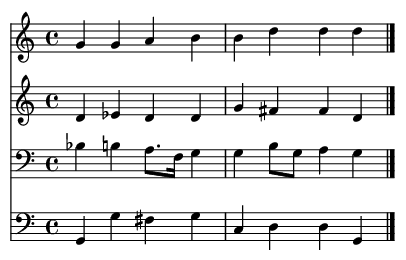

In [20]:
num_scores = 1
chords_random_latent_vectors = np.random.normal(size=(num_scores, Z_DIM))
style_random_latent_vectors = np.random.normal(size=(num_scores, Z_DIM))
melody_random_latent_vectors = np.random.normal(
    size=(num_scores, N_TRACKS, Z_DIM)
)
groove_random_latent_vectors = np.random.normal(
    size=(num_scores, N_TRACKS, Z_DIM)
)
random_latent_vectors = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music = generator(random_latent_vectors)
generated_music = generated_music.numpy()

notes_to_midi(
    generated_music, N_BARS, N_TRACKS, N_STEPS_PER_BAR, filename="output_midi"
)
display(Image(str(draw_score("output_midi", 0).write('lily.png'))))

## 화음 잡음 변경

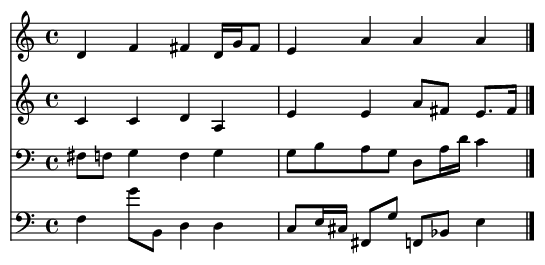

In [21]:
chords_random_latent_vectors_2 = np.random.normal(size=(num_scores, Z_DIM))
random_latent_vectors_2 = [
    chords_random_latent_vectors_2,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music_2 = generator(random_latent_vectors_2)
generated_music_2 = generated_music_2.numpy()
notes_to_midi(
    generated_music_2,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_chords_changed",
)
display(Image(str(draw_score("output_midi_chords_changed", 0).write('lily.png'))))

## 스타일 잡음 변경

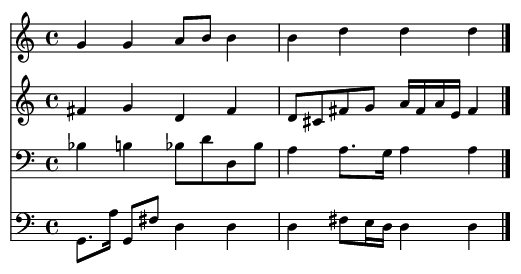

In [22]:
style_random_latent_vectors_2 = np.random.normal(size=(num_scores, Z_DIM))
random_latent_vectors_3 = [
    chords_random_latent_vectors,
    style_random_latent_vectors_2,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music_3 = generator(random_latent_vectors_3)
generated_music_3 = generated_music_3.numpy()
notes_to_midi(
    generated_music_3,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_style_changed",
)
display(Image(str(draw_score("output_midi_style_changed", 0).write('lily.png'))))

## 멜로디 잡음 변경

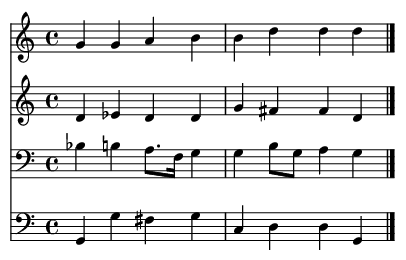

In [23]:
melody_random_latent_vectors_2 = np.copy(melody_random_latent_vectors)
melody_random_latent_vectors_2[:, 0, :] = np.random.normal(
    size=(num_scores, Z_DIM)
)

random_latent_vectors_4 = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors_2,
    groove_random_latent_vectors,
]
generated_music_4 = generator(random_latent_vectors_4)
generated_music_4 = generated_music_4.numpy()
notes_to_midi(
    generated_music_4,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_melody_changed",
)
display(Image(str(draw_score("output_midi_melody_changed", 0).write('lily.png'))))

## 리듬 잡음 변경

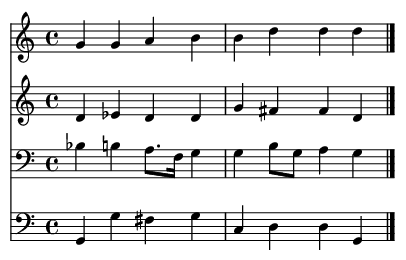

In [24]:
groove_random_latent_vectors_2 = np.copy(groove_random_latent_vectors)
groove_random_latent_vectors_2[:, -1, :] = np.random.normal(
    size=(num_scores, Z_DIM)
)

random_latent_vectors_5 = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors_2,
]
generated_music_5 = generator(random_latent_vectors_5)
generated_music_5 = generated_music_5.numpy()
notes_to_midi(
    generated_music_5,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_groove_changed",
)
display(Image(str(draw_score("output_midi_groove_changed", 0).write('lily.png'))))